In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import os
import sys
from copy import deepcopy
import itertools

project_dir = os.path.dirname(os.getcwd())
print(project_dir)
sys.path.append(project_dir)

from hydra import initialize
try:
    initialize(version_base=None, config_path="../sam2_logs/", job_name="predict_run")
except ValueError:
    pass

import matplotlib.pyplot as plt
import numpy as np
import supervision as sv
import torch
from torch.amp import autocast
from torchvision.transforms import ToPILImage, Normalize, Resize
from torchmetrics.detection import PanopticQuality
from training.dataset.transforms import ComposeAPI, NormalizeAPI

from helpers.configurations import TRACK_TO_METAINFO, LABEL_PROJECTION_MAP
from dataset.collate_fn import collate_fn
from dataset.mini_dataset import MiniDataset
from custom_model_builder import build_sam2former

/home/guests/tuna_gurbuz/prototype


In [4]:
model_size_dict = {
    # 'base': {
    #     'config': '04_28_00_50/config_resolved.yaml',
    #     'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/04_28_00_50/checkpoints/checkpoint_33.pt',
    #     },
    # 'base': {
    #     'config': '05_24_10_21/config_resolved.yaml',
    #     'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/05_24_10_21/checkpoints/checkpoint_34.pt',
    #     },
    'base1': {
        'config': '06_27_17_54/config_resolved.yaml',
        'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/07_12_10_18/checkpoints/checkpoint_50.pt',
        },
    'base2': {
        'config': '07_12_10_18/config_resolved.yaml',
        'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/07_12_10_18/checkpoints/checkpoint_51.pt',
        },
    'base3': {
        'config': '07_17_21_33/config_resolved.yaml',
        'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/07_17_21_33/checkpoints/checkpoint_65.pt',
        },
    'base4': {
        'config': '07_25_11_08/config_resolved.yaml',
        'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/07_26_09_10/checkpoints/checkpoint_69.pt',
        },
    'base5': {
        'config': '07_26_09_10/config_resolved.yaml',
        'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/07_25_11_08/checkpoints/checkpoint_75.pt',
        },
}

# Model
model_size = 'base3'
config = model_size_dict[model_size]['config']
ck = model_size_dict[model_size]['ck']
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
amp_type = torch.bfloat16 if device == 'cuda' else torch.float16
submodel, object_labels, _, loss, mean, std = build_sam2former(config, ck, device=device)
print(device)

OmegaConf resolved successfully


Frequency file exists. Using weights from frequency file
Using log loss weighting...
Using default weights
cuda


In [5]:
for ii in range(6):
    before = submodel.sam_mask_decoder.pixel_decoder.transformer.encoder.layers[ii].self_attn.attention_weights.weight
    # print("before", before)
    print(torch.all(before == 0))
sd = torch.load(ck, map_location="cpu", weights_only=True)["model"]
missing_keys, unexpected_keys = submodel.load_state_dict(sd, strict=False)
for ii in range(6):
    after = submodel.sam_mask_decoder.pixel_decoder.transformer.encoder.layers[ii].self_attn.attention_weights.weight
    # print("after", after)
    print(torch.all(after == 0))

tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


In [6]:
# Dataset
len_video = 1
input_image_size = 512
batch_size = 5
shuffle = False
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]
# revert_mean=[-.485/.229, -.456/.224, -.406/.225]
# revert_std=[1/.229, 1/.224, 1/.225]
#####
# mean = [0.3551, 0.3500, 0.3469]
# std = [0.2921, 0.2716, 0.2742]
# revert_mean=[-.3551/.2921, -.3500/.2716, -.3469/.2742]
# revert_std=[1/.2921, 1/.2716, 1/.2742]
#####
revert_mean = [-mean[0]/std[0], -mean[1]/std[1], -mean[2]/std[2]]
revert_std = [1/std[0], 1/std[1], 1/std[2]]
transforms = [ComposeAPI([NormalizeAPI(mean=mean, std=std, v2=True)])]
revert_transform = Normalize(mean=revert_mean, std=revert_std)
test_dataset = MiniDataset('test',
                           num_frames=len_video,
                           input_image_size=input_image_size,
                           object_labels=object_labels,
                           transforms=transforms,
                           collate_fn=collate_fn,
                           batch_size=batch_size,
                           get_seg_mask=True,
                           shuffle=shuffle,)
print(f'Lenght of the dataset! {len(test_dataset)}')

Loading the take 004_PKA!


3218it [00:01, 1624.61it/s]


Interpolated frames are not included! The number of frames in the cameras are not equal!
Last frame assertion failed due to exclusion of the interpolated frames!
Loading the take 011_TKA!


3128it [00:02, 1429.11it/s]


Interpolated frames are not included! The number of frames in the cameras are not equal!
Last frame assertion failed due to exclusion of the interpolated frames!
Loading the take 036_PKA!


4384it [00:03, 1367.28it/s]


Interpolated frames are not included! The number of frames in the cameras are not equal!
Last frame assertion failed due to exclusion of the interpolated frames!
Loading the take 038_TKA!


2876it [00:01, 1456.35it/s]

Interpolated frames are not included! The number of frames in the cameras are not equal!
Last frame assertion failed due to exclusion of the interpolated frames!
Lenght of the dataset! 11331


In [7]:
seed = 2 # Check seed 123 index 19966
torch.manual_seed(seed)
np.random.seed(seed)

# Image
len_objects = len(object_labels)
toPILimage = ToPILImage()
exist = False
if_break = False
# sample_idx = 950
# sample_idx = 2000
# sample_idx = 1250
# # sample_idx = 3993
# sample_idx = 278
sample_idx = 273
test_loader = test_dataset.get_loader()
flag_iter = False

# Run the model
with torch.no_grad():
    submodel.eval()
    if flag_iter:
        batch = next(itertools.islice(test_loader, sample_idx, None))
    else:
        batch = [test_dataset[i] for i in range(sample_idx * batch_size, (sample_idx+1) * batch_size) if i < len(test_dataset)]
        batch = collate_fn(batch, 'val')
    batched_video_data_val = batch.to(device)
    # batch_seg_mask_gt = batch[1]  # List of PIL Image for debug
    masks_val = batch.masks.to(device)
    with autocast(device_type=device, dtype=amp_type):
        all_frame_outputs_val = submodel(batched_video_data_val)

In [8]:
[test_dataset.images[i] for i in range(sample_idx * batch_size, (sample_idx+1) * batch_size)]

[array([PosixPath('/home/polyaxon-data/data1/MM-OR_processed/004_PKA/colorimage/camera01_colorimage-001632.jpg')],
       dtype=object),
 array([PosixPath('/home/polyaxon-data/data1/MM-OR_processed/004_PKA/colorimage/camera04_colorimage-001450.jpg')],
       dtype=object),
 array([PosixPath('/home/polyaxon-data/data1/MM-OR_processed/004_PKA/colorimage/camera05_colorimage-001325.jpg')],
       dtype=object),
 array([PosixPath('/home/polyaxon-data/data1/MM-OR_processed/004_PKA/colorimage/camera01_colorimage-001638.jpg')],
       dtype=object),
 array([PosixPath('/home/polyaxon-data/data1/MM-OR_processed/004_PKA/colorimage/camera04_colorimage-001456.jpg')],
       dtype=object)]

In [9]:
# Adapt to new changes
all_frame_outputs_val = all_frame_outputs_val[0]

# Convert mask prediction logits to binary masks
binary_pred_masks = all_frame_outputs_val[0]['pred_masks_high_res'].sigmoid() > 0.5
binary_pred_masks = binary_pred_masks.cpu().numpy()

# Convert class logits to class predictions
pred_logits = all_frame_outputs_val[0]['pred_logits'].type(torch.float32).softmax(-1).cpu().numpy()
pred_class = pred_logits.argmax(-1)

B, N, H, W = binary_pred_masks.shape  # Size with padding
gt_labels = batched_video_data_val.metadata.unique_objects_identifier[:,:,1]

In [10]:
# import json
# dump_dict = {k: v.cpu().type(torch.float32).numpy().tolist() for k,v in all_frame_outputs_val[0].items() if k != 'aux_outputs'}
# with open('../temp/predictions.json', 'w') as f:
#     json.dump(dump_dict, f)

In [ ]:
op_table_masks = binary_pred_masks[np.where(pred_class == 2)]

In [12]:
pred_class, gt_labels

(array([[15,  9,  3,  2, 13, 13, 16,  7, 19, 17,  5,  8, 18,  6,  1,  9,
         14,  6, 10,  0, 11,  4, 12],
        [15,  9,  3,  2, 14, 13, 16,  7, 19, 17,  5, 13, 18, 10,  1,  8,
         14,  6, 10,  0, 11,  4, 12],
        [15,  8,  3,  2, 14, 13, 16,  7, 19, 17,  5,  8, 18,  6,  1,  9,
         14,  6, 10,  0, 11,  4, 12],
        [15,  9,  3,  2, 13, 13, 16,  7, 19, 17,  5,  8, 18, 10,  1,  9,
         14,  6, 10,  0, 11,  4, 12],
        [15,  8,  3,  2, 14, 13, 16,  7, 19, 17,  5, 13, 18,  6,  1,  9,
         14,  6, 10,  0, 11,  4, 12]]),
 tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
          13, 14, 15, 16, 17, 18, 19, 20, 21, 22,  0,  1,  2,  3,  4,  5,  6,  7,
           8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,  0,  1,  2,
           3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
          21, 22,  0,  1,  2,  3,

In [13]:
# THIS PART IS ONLY VALID IF ALL THE IMAGES ARE AZURE
# # Ground truth mask
# seg_mask_gt = np.array(batch_seg_mask_gt)  # Convert from PIL to numpy
# seg_mask_gt = seg_mask_gt.squeeze(1) if len(seg_mask_gt.shape) == 5 else seg_mask_gt  # Reshape to 3 dimensions

# # Sizes and resizing
# B, N, H, W = binary_pred_masks.shape  # Size with padding
# H_full, W_full = seg_mask_gt.shape[-3:-1]
# resize_factor = W_full // W
# resize_shape = [H_full // resize_factor, W_full // resize_factor]
# resize_image = Resize(resize_shape)

# # Revert the padded mask coming out of the model
# padding_size = (H - resize_shape[0]) // 2
# binary_pred_masks = binary_pred_masks[:,:, padding_size : H-padding_size, :]
# H, W = binary_pred_masks.shape[2:]

In [14]:
def get_color_map():
    color_map = {}
    for k, v in LABEL_PROJECTION_MAP['default'].items():
        # if k > 7 and v['label'] == 6:
        #     continue
        r, g, b = v['color']
        color_map[v['label']] = (r,g,b)
    return color_map

# Get color map
color_map = get_color_map()

In [15]:
# Prepare segmentation mask and RGB mask with color encoding
pred_seg_class_mask = np.ones((B, 1, H, W), dtype=np.int8) * 23  # 16 is the background class
pred_rgb_mask = np.zeros((B, H, W, 3), dtype=np.uint8)
for _b_idx, (_b_binary_pred_masks, _b_pred_class) in enumerate(zip(binary_pred_masks, pred_class)):
    #TODO if class_id == background pass
    for mask, class_id in zip(_b_binary_pred_masks, _b_pred_class):
        pos = np.where(mask == True)
        if len(pos[0]) > 0:
            pred_seg_class_mask[_b_idx, 0, pos[0], pos[1]] = class_id
            pred_rgb_mask[_b_idx, pos[0], pos[1], :] = color_map[class_id]
        else:
            continue

In [16]:
gt_seg_class_mask = np.ones((B, 1, H, W), dtype=np.int8) * 23  # 16 is the background class
gt_rgb_mask = np.zeros((B, H, W, 3), dtype=np.uint8)
for batch_idx in range(B):
    pos = batched_video_data_val.obj_to_frame_idx[0,:,1] == batch_idx  # The objects in the batch are mixed
    gt_mask = masks_val[0, pos, :, :].cpu().numpy()  # Get the GT masks in the batch
    gt_class_id = gt_labels[0, pos].cpu().numpy()  # Get the GT class id in the batch
    for mask, class_id in zip(gt_mask, gt_class_id):
        pos = np.where(mask == True)
        if len(pos[0]) > 0:
            gt_seg_class_mask[batch_idx, 0, pos[0], pos[1]] = class_id
            gt_rgb_mask[batch_idx, pos[0], pos[1], :] = color_map[class_id]
        else:
            continue

In [17]:
# THIS PART IS ONLY VALID IF ALL THE IMAGES ARE AZURE
# Prepare GT segmentation mask and RGB mask with color encoding
# gt_seg_class_mask = np.ones((B, 1, H, W), dtype=np.int8) * 16  # 16 is the background class
# gt_rgb_mask = np.zeros((B, H_full, W_full, 3), dtype=np.uint8)
# for _b_idx, _b_seg_mask_gt in enumerate(seg_mask_gt):
#     for label in object_labels:
#         downsample_gt_mask = resize_image(torch.tensor(_b_seg_mask_gt[:,:,1] == label).unsqueeze(0))[0]
#         pos_dws = np.where(downsample_gt_mask == True)
#         pos_rgb = np.where(_b_seg_mask_gt[:,:,1] == label)
#         if len(pos_rgb[0]) > 0:
#             projected_label = LABEL_PROJECTION_MAP[label]['label']
#             gt_rgb_mask[_b_idx, pos_rgb[0], pos_rgb[1], :] = color_map[projected_label]
#             gt_seg_class_mask[_b_idx, 0, pos_dws[0], pos_dws[1]] = projected_label
#         else:
#             continue

In [18]:
# Initialize lists for masks
pred_rgb_mask_list_azure = []
pred_seg_class_mask_list_azure = []
gt_rgb_mask_list_azure = []
gt_seg_class_mask_list_azure = []

pred_rgb_mask_list_sim = []  # Auxillary lists for now
pred_seg_class_mask_list_sim = []  # Auxillary lists for now
gt_rgb_mask_list_sim = []  # Auxillary lists for now
gt_seg_class_mask_list_sim = []  # Auxillary lists for now

# Revert the padding
for batch_idx in range(B):
    # Load the corresponding rgb image to look for padding 
    img = batched_video_data_val.img_batch[0][batch_idx].permute(1,2,0).cpu().numpy()
    
    # Check if the image is black (0,0,0) along the height dimension
    is_black_row = (img[:,:,0] <= 0)  # Check along width and channels
    pos_padding = np.where(is_black_row == False)
    start = pos_padding[0][0]
    end = pos_padding[0][-1]
    
    # Slice the predictions and ground truth masks
    if start == 64:
        pred_rgb_mask_list_azure.append(pred_rgb_mask[batch_idx, start:end+1, :, :])
        pred_seg_class_mask_list_azure.append(pred_seg_class_mask[batch_idx, 0:1, start:end+1, :])
        gt_rgb_mask_list_azure.append(gt_rgb_mask[batch_idx, start:end+1, :, :])
        gt_seg_class_mask_list_azure.append(gt_seg_class_mask[batch_idx, 0:1, start:end+1, :])
    elif start == 0:
        pass
    else:
        raise ValueError("Padding not found in the image")

# Concatenate the masks
pred_rgb_mask = np.array(pred_rgb_mask_list_azure)
pred_seg_class_mask = np.array(pred_seg_class_mask_list_azure)
gt_rgb_mask = np.array(gt_rgb_mask_list_azure)
gt_seg_class_mask = np.array(gt_seg_class_mask_list_azure)

### Color encoded segmentation masks and label encoded segmentation masks

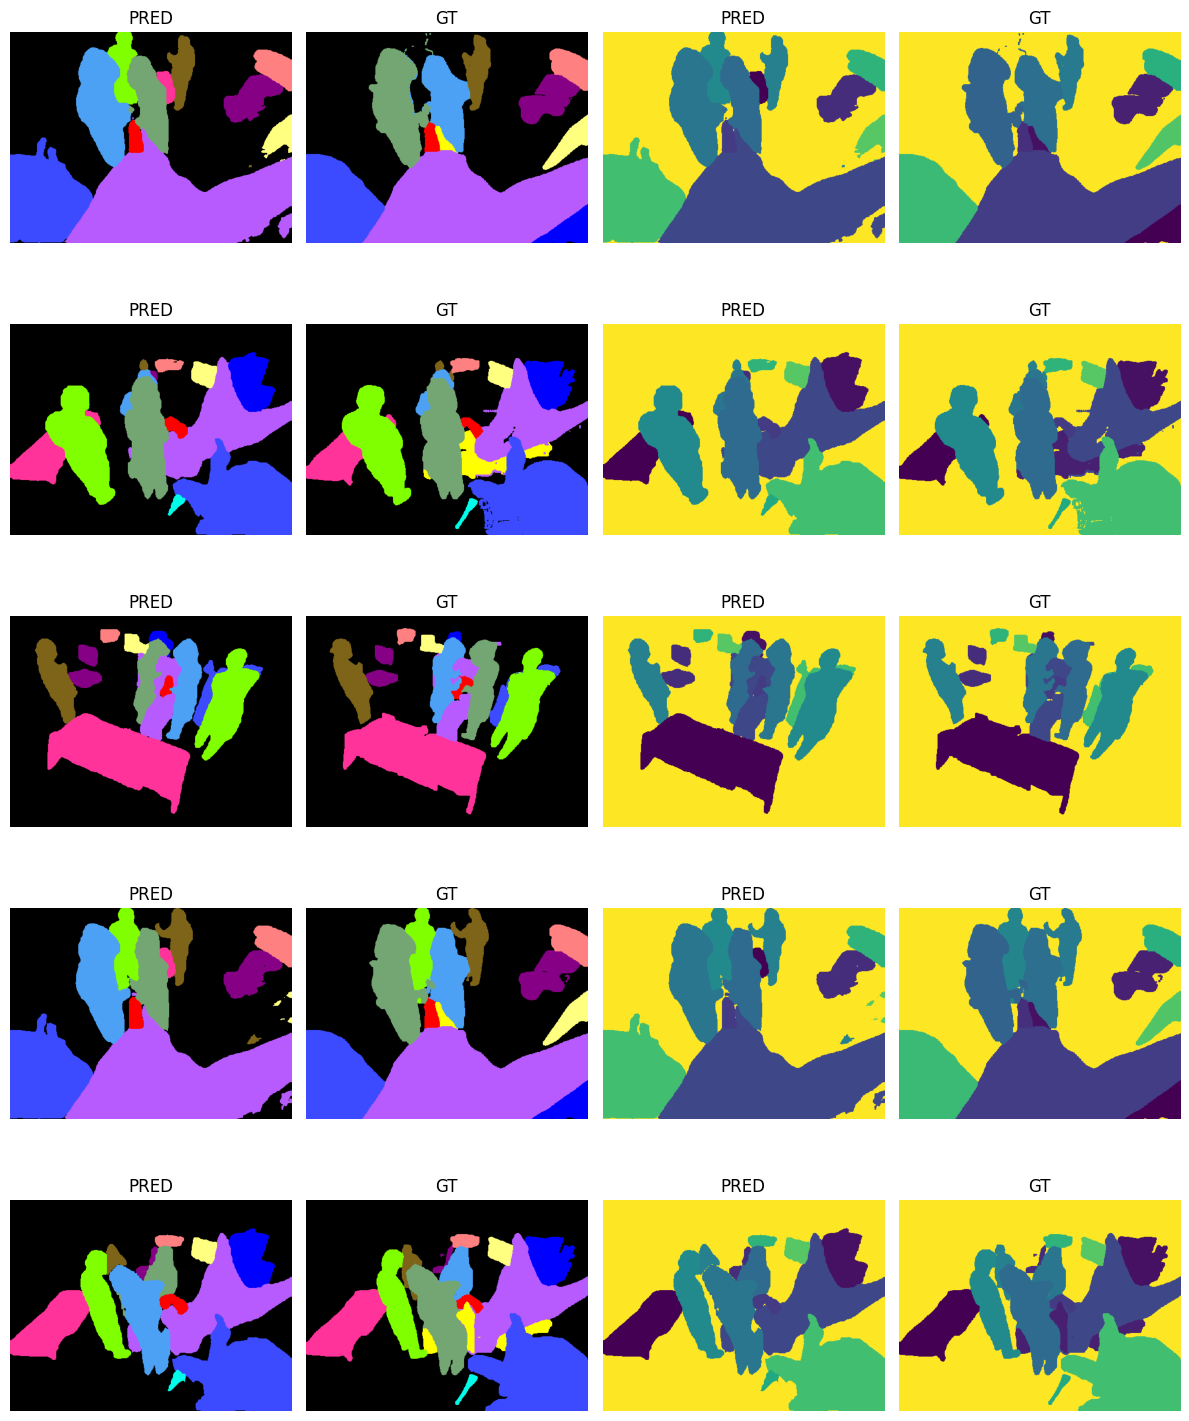

In [19]:
figsize = np.array([4, B]) * 3
fig, axs = plt.subplots(B, 4, figsize=figsize, )

for ii in range(B):
    axs[ii,0].imshow(pred_rgb_mask[ii])
    axs[ii,0].axis('off')
    axs[ii,0].set_title('PRED')

    axs[ii,1].imshow(gt_rgb_mask[ii])
    axs[ii,1].axis('off')
    axs[ii,1].set_title('GT')

    axs[ii,2].imshow(pred_seg_class_mask[ii, 0])
    axs[ii,2].axis('off')
    axs[ii,2].set_title('PRED')

    axs[ii,3].imshow(gt_seg_class_mask[ii, 0])
    axs[ii,3].axis('off')
    axs[ii,3].set_title('GT')

plt.tight_layout()
plt.show()

### Calculate Panoptic Quality (PQ)

In [20]:
# Stuff: 16, Things: 17 Instance labels: 0-15
background = 23
things = {LABEL_PROJECTION_MAP['default'][idx]['label'] for idx in object_labels}
stuff = {background}  # Putting 17 does not change anything for the last value
print(f'Things: {things}\nStuff: {stuff}')

# Prepare stuff and things mask for prediction
preds = pred_seg_class_mask[:, 0, :, :, None]
instance_ids = np.zeros_like(preds)  # Almost like semantic segmentation, therefore all objects are the first instances
preds = np.concatenate((preds, instance_ids), axis=3)

# Prepare stuff and things mask for GT
target = gt_seg_class_mask[:, 0, :, :, None]
instance_ids_gt = np.zeros_like(target)  # Almost like semantic segmentation, therefore all objects are the first instances
target = np.concatenate((target, instance_ids_gt), axis=3)

# Convert to torch tensors
preds = torch.tensor(preds)
target = torch.tensor(target)

# Prepare panoptic quality metric
panoptic_quality = PanopticQuality(stuffs=stuff, things=things)
pq = panoptic_quality(preds, target)
print(f'Prediction: {preds.shape}, Target: {target.shape}')
print(f"PQ: {pq}")

if False:
    # Corrected PQ calculation
    background = 23
    things = {LABEL_PROJECTION_MAP[idx]['label'] for idx in object_labels}
    stuff = {background}  # Only background is stuff
    print(f'Things: {things}\nStuff: {stuff}')

    # Create panoptic masks with unique instance IDs
    pred_panoptic = np.full((B, H, W), background, dtype=np.int32)  # Start with background
    target_panoptic = np.full((B, H, W), background, dtype=np.int32)

    # For predictions
    for batch_idx in range(B):
        for mask_idx, (mask, class_id) in enumerate(zip(binary_pred_masks[batch_idx], pred_class[batch_idx])):
            if mask.any():  # If mask is not empty
                pred_panoptic[batch_idx][mask] = class_id
    instance_ids = np.zeros_like(pred_panoptic)  # Almost like semantic segmentation, therefore all objects are the first instances
    pred_panoptic = np.stack((pred_panoptic, instance_ids), axis=3)

    # For ground truth
    for batch_idx in range(B):
        pos = batched_video_data_val.obj_to_frame_idx[0,:,1] == batch_idx
        gt_mask = masks_val[0, pos, :, :].cpu().numpy()
        for mask_idx, mask in enumerate(gt_mask):
            if mask.any():  # If mask is not empty
                target_panoptic[batch_idx][mask] = mask_idx
    instance_ids_gt = np.zeros_like(target_panoptic)  # Almost like semantic segmentation, therefore all objects are the first instances
    target_panoptic = np.stack((target_panoptic, instance_ids_gt), axis=3)

    # Convert to torch tensors
    pred_panoptic = torch.tensor(pred_panoptic)
    target_panoptic = torch.tensor(target_panoptic)

    # Calculate PQ
    panoptic_quality = PanopticQuality(things=things, stuffs=stuff)
    pq = panoptic_quality(pred_panoptic, target_panoptic)
    print(f"Corrected PQ: {pq}")

Things: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}
Stuff: {23}


Prediction: torch.Size([5, 384, 512, 2]), Target: torch.Size([5, 384, 512, 2])
PQ: 0.5625855553074601


# Prepare Masks on Image

In [21]:
# batch = batch[0]
# batch_size = len(batch.img_batch)
# key = batch.dict_key  # key for dataset
# targets = []

# for i in range(batch_size):
#     # dim=2 video_id, obj_id, frame_id
#     xx, yy = torch.where(batch.metadata.unique_objects_identifier[:,:,2] == i)
#     obj_id = batch.metadata.unique_objects_identifier[xx,yy,1]
#     targets.append({
#         "masks": batch.masks[i],
#         "labels": obj_id,
#     })
    
# loss[key](all_frame_outputs_val, targets)

batched_video_data_val.img_batch.shape = (N, B, C, H, W)  
masks_val.shape = (N, B*O, H, W)  
metadata.unique_objects_identifier = (N, B*O, 3) => [video_id, object_id, frame_id]  
obj_to_frame_idx = (N, B*O, 2) => [video_id, frame_id]  

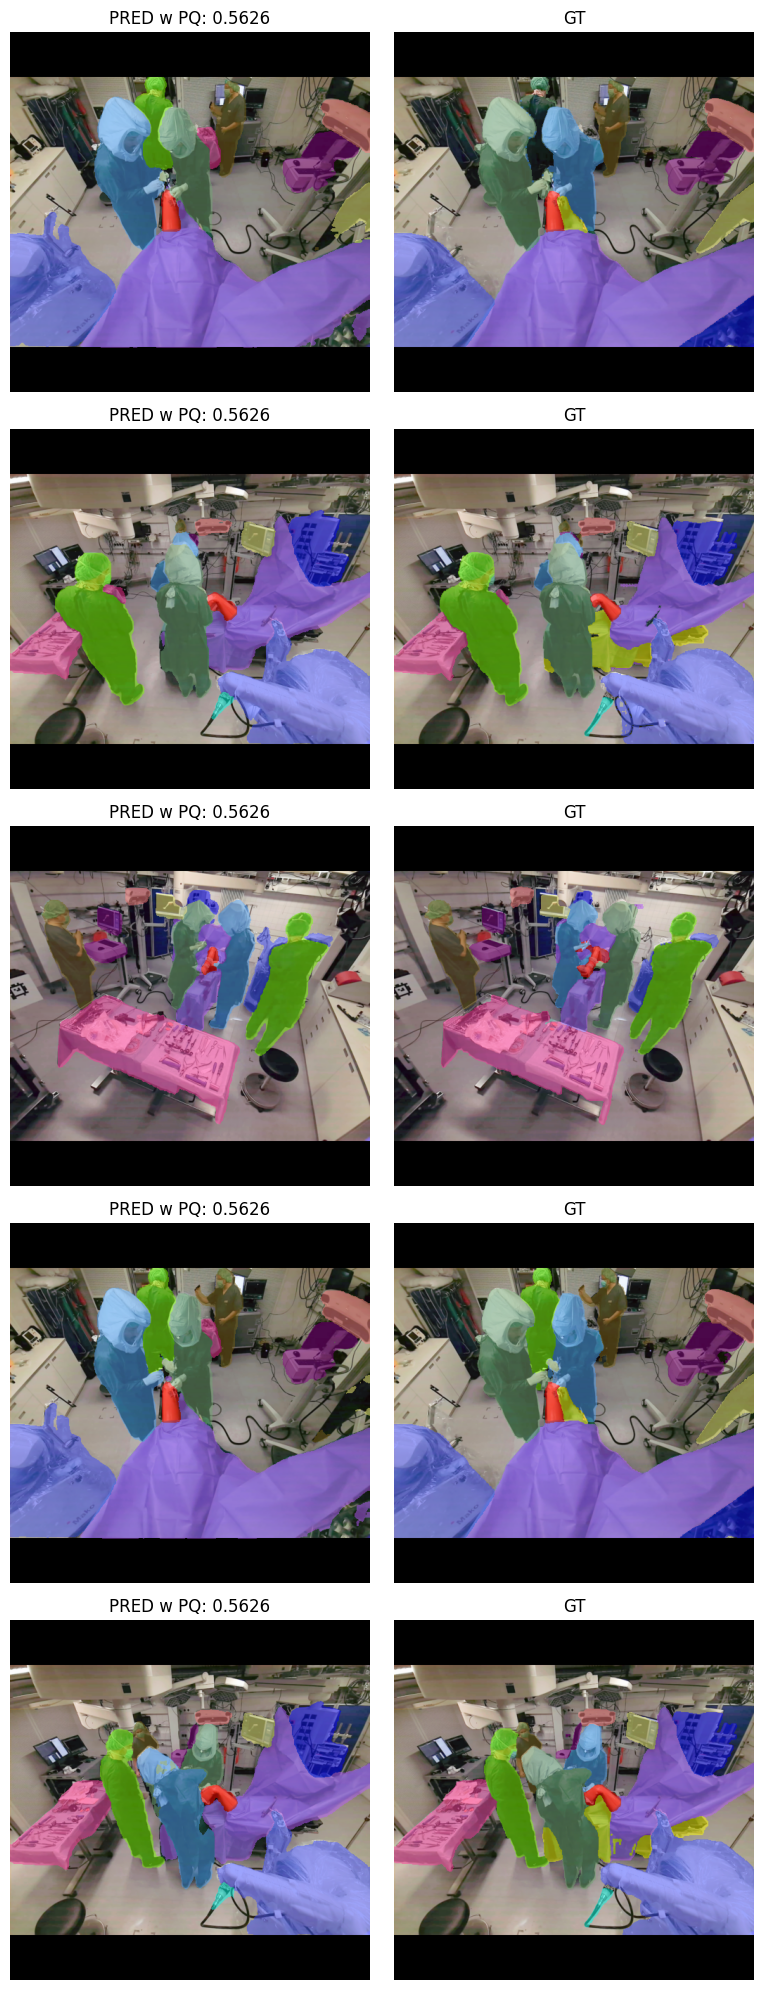

In [22]:
def get_color_map():
    color_map = []
    for k, v in LABEL_PROJECTION_MAP['default'].items():
        # if k > 7 and v['label'] == 6:
        #     continue
        r, g, b = v['color']
        color_map.append(sv.Color(r,g,b))
    color_map = sv.ColorPalette(colors=color_map)
    return color_map

# Get color map
color_map = get_color_map()

# GT Labels
gt_labels = batched_video_data_val.metadata.unique_objects_identifier[:,:,1]

# Create subplots
figsize = np.array([2, B]) * 4
fig, axs = plt.subplots(B, 2, figsize=figsize, )

for batch_idx in range(B):
    # Unnormalize the image
    image = batched_video_data_val.img_batch[0][batch_idx]
    unnormalized_image = toPILimage(revert_transform(image))

    # GT masks
    pos = batched_video_data_val.obj_to_frame_idx[0,:,1] == batch_idx
    gt_mask = masks_val[0, pos, :, :].cpu().numpy()
    gt_class_id = gt_labels[0, pos].cpu().numpy()
    empty_bboxes = np.array([[0, 0, 0, 0]] * len(gt_class_id))

    # Gt Annotated Frame 
    gt_detections = sv.Detections(xyxy=empty_bboxes, mask=gt_mask, class_id=gt_class_id)
    mask_annotator = sv.MaskAnnotator(color=color_map)
    gt_annotated_frame = mask_annotator.annotate(
        scene=unnormalized_image.copy(),
        detections=gt_detections
    )
    # sv.plot_image(gt_annotated_frame, size=(4,4)) if B <= 10 else None

    # Prediction masks
    pred_mask = (all_frame_outputs_val[0]['pred_masks_high_res'][batch_idx].sigmoid() > 0.5).cpu().numpy()
    # pred_class_ids = best_probs.indices.numpy().astype(np.int32)
    empty_bboxes = np.array([[0, 0, 0, 0]] * len(pred_class[0]))

    # Prediction Annotated Frame
    pred_detections = sv.Detections(xyxy=empty_bboxes, mask=pred_mask, class_id=pred_class[batch_idx])
    mask_annotator = sv.MaskAnnotator(color=color_map)
    pred_annotated_frame = mask_annotator.annotate(
        scene=unnormalized_image.copy(),
        detections=pred_detections
    )
    # sv.plot_image(pred_annotated_frame, size=(4,4)) if B <= 10 else None
    axs[batch_idx,0].imshow(pred_annotated_frame, )
    axs[batch_idx,0].axis('off')
    axs[batch_idx,0].set_title(f'PRED w PQ: {pq:.4f}')

    axs[batch_idx,1].imshow(gt_annotated_frame)
    axs[batch_idx,1].axis('off')
    axs[batch_idx,1].set_title('GT')

plt.tight_layout()
plt.show()
# plt.savefig('../temp/pred_gt.png', dpi=150)

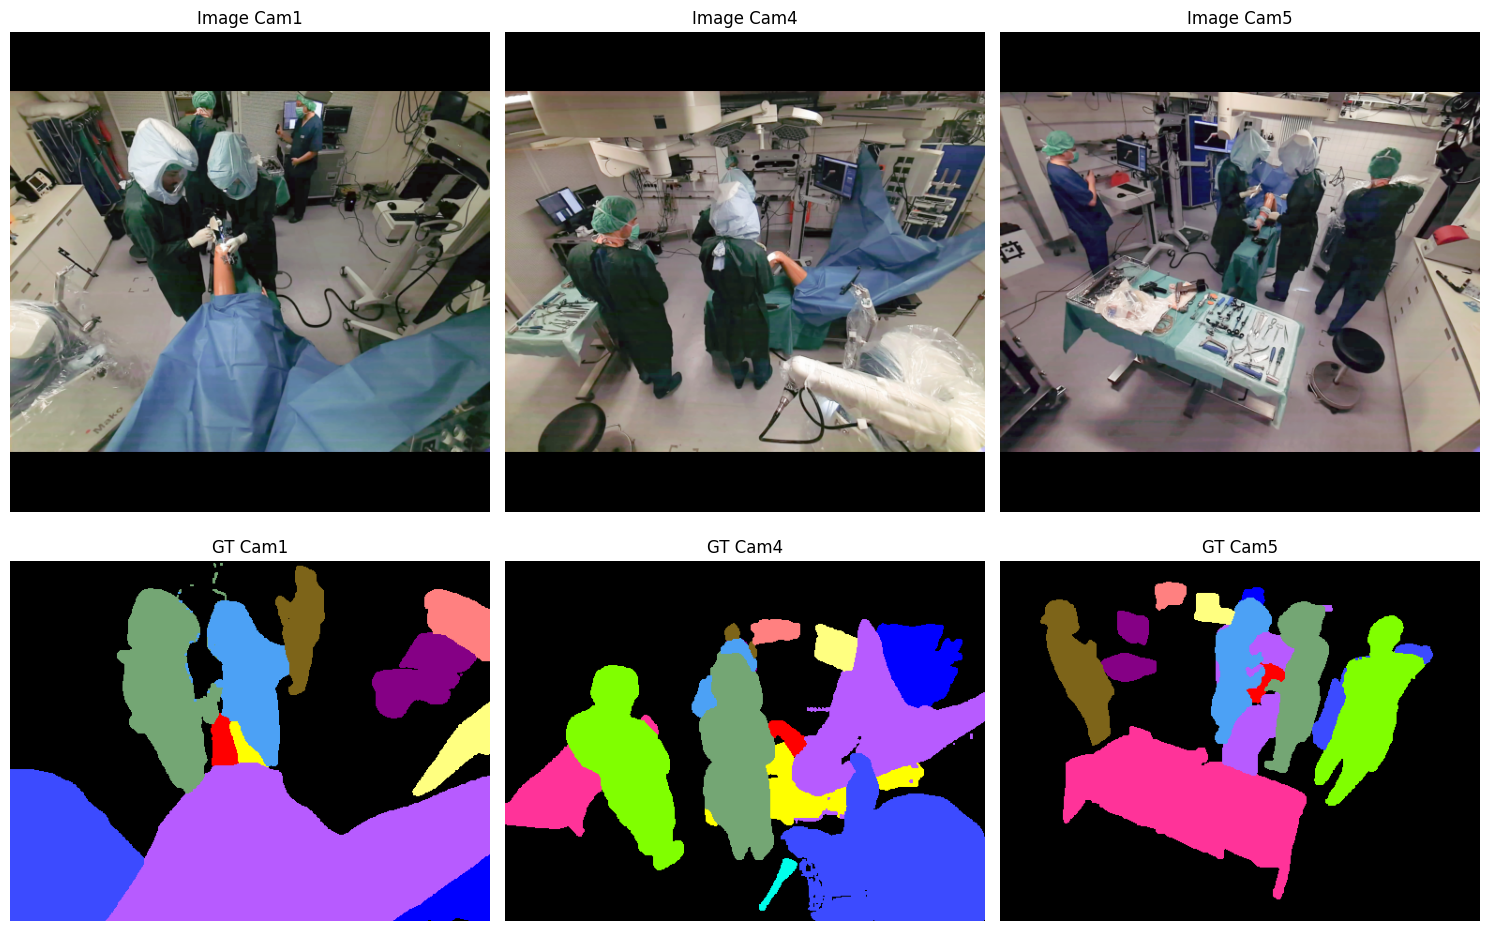

In [23]:
ii_to_cam_dict = {0: 'Cam1', 1: 'Cam4', 2: 'Cam5'}
fig_size = np.array([3, 2]) * 5
fig, axs = plt.subplots(2, 3, figsize=fig_size)
for ii in range(3):
    image = batched_video_data_val.img_batch[0][ii]
    unnormalized_image = toPILimage(revert_transform(image))
    axs[0, ii].imshow(unnormalized_image)
    axs[0, ii].axis('off')
    axs[0, ii].set_title(f"Image {ii_to_cam_dict[ii]}")

    axs[1, ii].imshow(gt_rgb_mask[ii])
    axs[1, ii].axis('off')
    axs[1, ii].set_title(f"GT {ii_to_cam_dict[ii]}")

plt.tight_layout()
plt.show()